In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "/media/mountHDD2/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "/media/mountHDD2/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([3, 256, 256])
Number classes: [0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


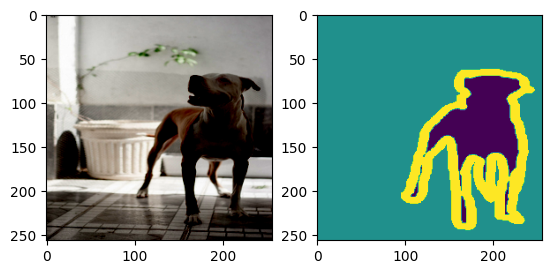

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.argmax(0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
class VanillaSegV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.act = nn.Softmax(dim=1)

    def forward(self, pred, target) -> torch.Tensor:

        cls_loss = {}

        pred_soft = self.act(pred)

        logits = torch.log2(pred_soft)

        B, C, H, W = tuple(logits.size())

        _logits = logits.permute(0, 2, 3, 1).flatten(0, -2)
        _target = target.permute(0, 2, 3, 1).flatten(0, -2)

        for cidx in range(C):
            c_logits = _logits[_target[:, cidx] == 1]
            c_target = _target[_target[:, cidx] == 1]

            entropy = torch.sum(c_logits * c_target)

            cls_loss[cidx] = entropy

        return (-1 / (B * H * W)) * sum(list(cls_loss.values()))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 3, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 20

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

# loss_fn = nn.CrossEntropyLoss()
loss_fn = VanillaSegV0()

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)

            valid_gen_img = model(valid_img)
            valid_loss = loss_fn(valid_gen_img, valid_mask.squeeze(1))

            va_total_loss += valid_loss.item()

    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")

model.load_state_dict(best_dct)

100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 0 - TrainLoss: 1.1024296900321697 - ValidLoss: 1.3324492039351628


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 1 - TrainLoss: 0.8431963992529902 - ValidLoss: 0.8228925949540632


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.32it/s]


Epoch: 2 - TrainLoss: 0.7440018818296236 - ValidLoss: 0.713638556414637


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch: 3 - TrainLoss: 0.643249099624568 - ValidLoss: 0.6412318708567784


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.14it/s]


Epoch: 4 - TrainLoss: 0.5906217519579262 - ValidLoss: 0.5683127395037947


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.18it/s]


Epoch: 5 - TrainLoss: 0.5468244809528877 - ValidLoss: 0.5278735864779045


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.31it/s]


Epoch: 6 - TrainLoss: 0.5080551618132098 - ValidLoss: 0.5206561211881966


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.31it/s]


Epoch: 7 - TrainLoss: 0.49455982960503675 - ValidLoss: 0.5226904307973796


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.15it/s]


Epoch: 8 - TrainLoss: 0.46967475681469356 - ValidLoss: 0.5723828796682686


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch: 9 - TrainLoss: 0.44394503020007037 - ValidLoss: 0.4434133249110189


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.18it/s]


Epoch: 10 - TrainLoss: 0.41784721099097155 - ValidLoss: 0.4510576360184571


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.10it/s]


Epoch: 11 - TrainLoss: 0.40518755080371066 - ValidLoss: 0.45447254335058146


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.23it/s]


Epoch: 12 - TrainLoss: 0.3858688083188287 - ValidLoss: 0.41553111117461633


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.18it/s]


Epoch: 13 - TrainLoss: 0.3723307853115016 - ValidLoss: 0.4104938388898455


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.37it/s]


Epoch: 14 - TrainLoss: 0.35547261351141435 - ValidLoss: 0.4160344158780986


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 15 - TrainLoss: 0.342526699448454 - ValidLoss: 0.4079385877683245


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.29it/s]


Epoch: 16 - TrainLoss: 0.33046519602167196 - ValidLoss: 0.40517240351644057


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 17 - TrainLoss: 0.3213134592977063 - ValidLoss: 0.4052719319688863


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch: 18 - TrainLoss: 0.3189409565308998 - ValidLoss: 0.40796452709313097


100%|█████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.35it/s]

Epoch: 19 - TrainLoss: 0.3149405538008131 - ValidLoss: 0.40319413768834084


<All keys matched successfully>

  0%|                                                                          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|█████████████▏                                                    | 2/10 [00:00<00:00, 16.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the

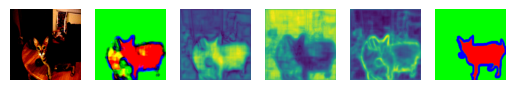

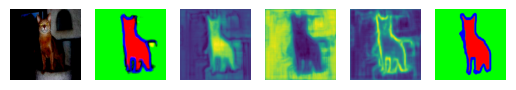

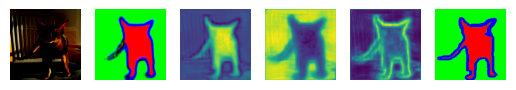

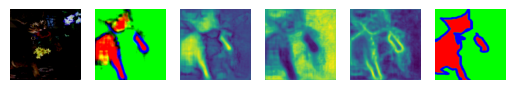

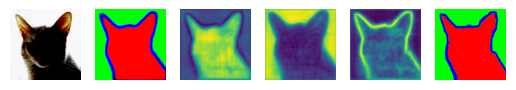

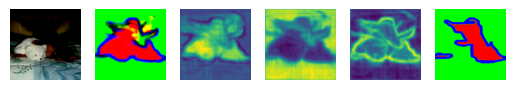

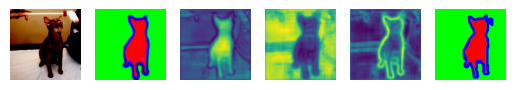

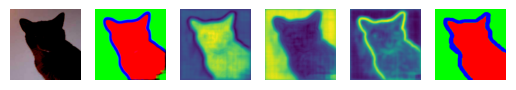

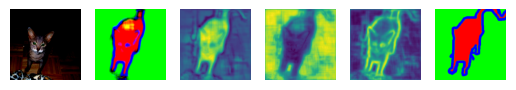

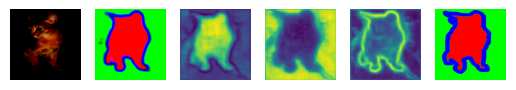

In [14]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')